In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import imp
import sys
import scipy
import pickle as plk
import importlib.util
from numpy.lib.scimath import sqrt as csqrt
from IPython.display import display, Math, clear_output
from scipy.signal import find_peaks

###############################################################
#LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/media/leonardo/datam02/Edge-Coupler')) #Current directory

###############################################################
#WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Leo/Documents/Facul/Capacitação/GitHub/Edge-Coupler'))
spec_win.loader.exec_module(lumapi)


def imbalance(n,p):
    return 10*np.log10(p/n)

def CMRR(n,p):
    return 20*np.log10(abs((p-n)/(p+n)))

def functionstapers(lenght, N, width, function): # Generate polygons with the given function
    yinvertido = np.flip(-function)
    xinvertido = np.linspace(lenght,0,N)
    X = np.append(x,xinvertido)
    Y = np.append(function,yinvertido)
    vertices = np.column_stack((X,Y))
    lum.addpoly()
    lum.set('vertices',vertices)
    return X, Y, xinvertido, yinvertido

# Parameters and variables

core = 'Si (Silicon) - Palik'
substract = 'SiO2 (Glass) - Palik'

height = 0.34e-6
burriedlayer = 2e-6
finalwidth = 0.55e-6

Cband = np.linspace(1.530e-6, 1.565e-6, 2000)
band = np.linspace(1500e-9, 1600e-9, 2000)
c0 = 299792458

width = 0.04e-6
length = 200e-6
N = 2000

time = 5e-12

yspan = 8.5e-6
zspan = 8.5e-6


C:\Users\Leo\AppData\Local\Temp\ipykernel_16784\3713037330.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


# Linear

In [3]:
lum = lumapi.FDTD(filename='../CML/Linear.fsp')
#lum = lumapi.MODE(filename='../CML/Linear.lms')

In [3]:
# Core and substract generation

# Using 0.04μm width and 200μm length
lum.select('core')
lum.delete()
lum.select('substract')
lum.delete()
lum.select('extension')
lum.delete()


x = np.linspace(0,length,N)
m = (width-finalwidth)/(length-0)/2
function = m*x + finalwidth/2
inversefunction = function[::-1]

functionstapers(length, N, width, inversefunction)
lum.set({
    'z min'                                      : 0,
    'z max'                                      : height,
    'x'                                          : 0,
    'y'                                          : 0,
    'material'                                   : core,
    'name'                                       : 'core',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})
lum.addrect()
lum.set({
    'x min'                                      : length,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : finalwidth,
    'z max'                                      : height,
    'z min'                                      : 0,
    'name'                                       : 'extension',
    'material'                                   : core,
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})

lum.addrect()
lum.set({
    'z'                                          : 0,
    'z span'                                     : 2*burriedlayer,
    'x min'                                      : 0,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : 3*burriedlayer,
    'material'                                   : substract,
    'name'                                       : 'substract',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 2
})


In [5]:
# Simulation Settings

#time = (length)/c0*3.5
#print(time)

lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()

lum.addpower()
lum.set({
    'z'                               : height/2,
    'x'                               : length/2,
    'x span'                          : length + 5e-6,
    'y'                               : 0,
    'y span'                          : yspan,
    'name'                            : 'field',
    'override global monitor settings':1,
    'frequency points'                : 200
})

lum.addpower()
lum.set('monitor type', '2D X-normal')
lum.set({
    'z'                               : height/2,
    'z span'                          : zspan,
    'x'                               : length + 2e-6,
    'y'                               : 0,
    'y span'                          : yspan,
    'name'                            : 'output',
    'override global monitor settings':1,
    'frequency points'                : 200
})

lum.addmode()
lum.set({
    'x'                : -2.5e-6,
    'y'                : 0,
    'y span'           : yspan,
    'z'                : height/2,
    'z span'           : zspan,
    'name'             : 'port',
    'wavelength start' : 1.5e-6,
    'wavelength stop'  : 1.6e-6
})

lum.addfdtd()
lum.set({
    'z'               : height/2,
    'z span'          : zspan,
    'x'               : length/2,
    'x span'          : length+5e-6,
    'y'               : 0,
    'y span'          : yspan,
    'mesh accuracy'   : 2,
    #'y min bc'        : 'Anti-Symmetric',
    'z min bc'        : 'Symmetric',
    'simulation time' : time
})

lum.addmesh()
lum.set({
    'based on structure' : 1,
    'z span'          : zspan,
    'x'               : length/2,
    'x span'          : length+5e-6,
    'y'               : 0,
    'y span'          : yspan,
    'mesh accuracy'   : 2,
    #'y min bc'        : 'Anti-Symmetric',
    'z min bc'        : 'Symmetric',
    'simulation time' : time
})

: 

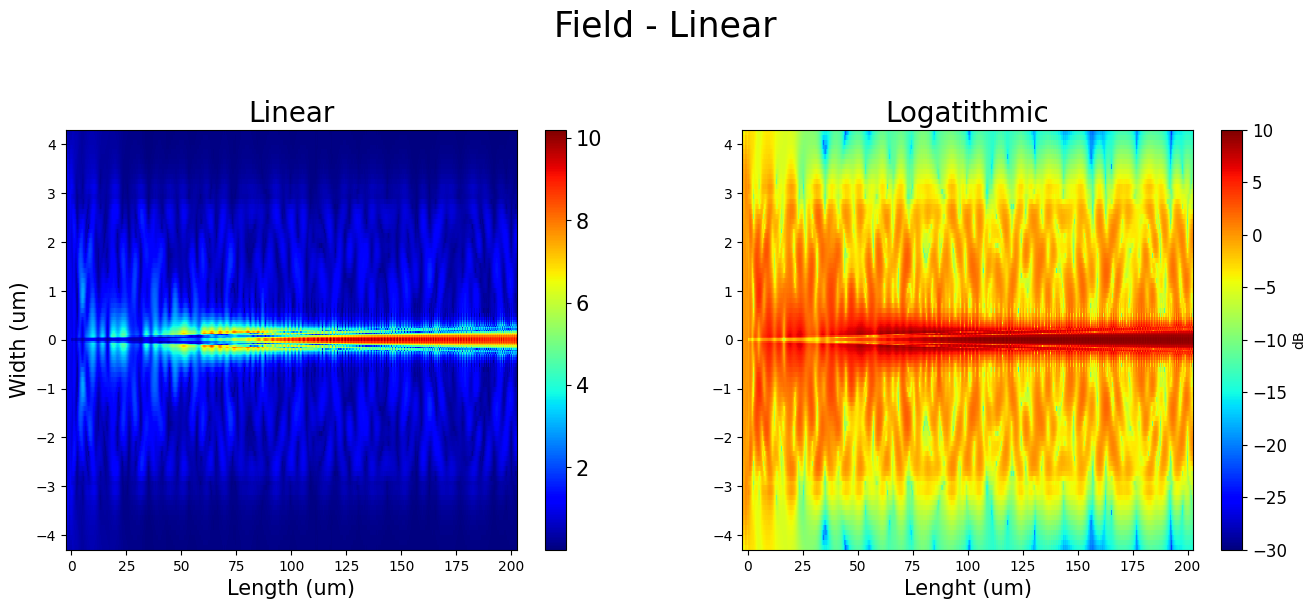

In [4]:
# Plot Linear and Log TE Mode Field Monitor Graph

figure1 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = lum.getresult('field','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.suptitle('Field - Linear', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 10)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitor_Linear')

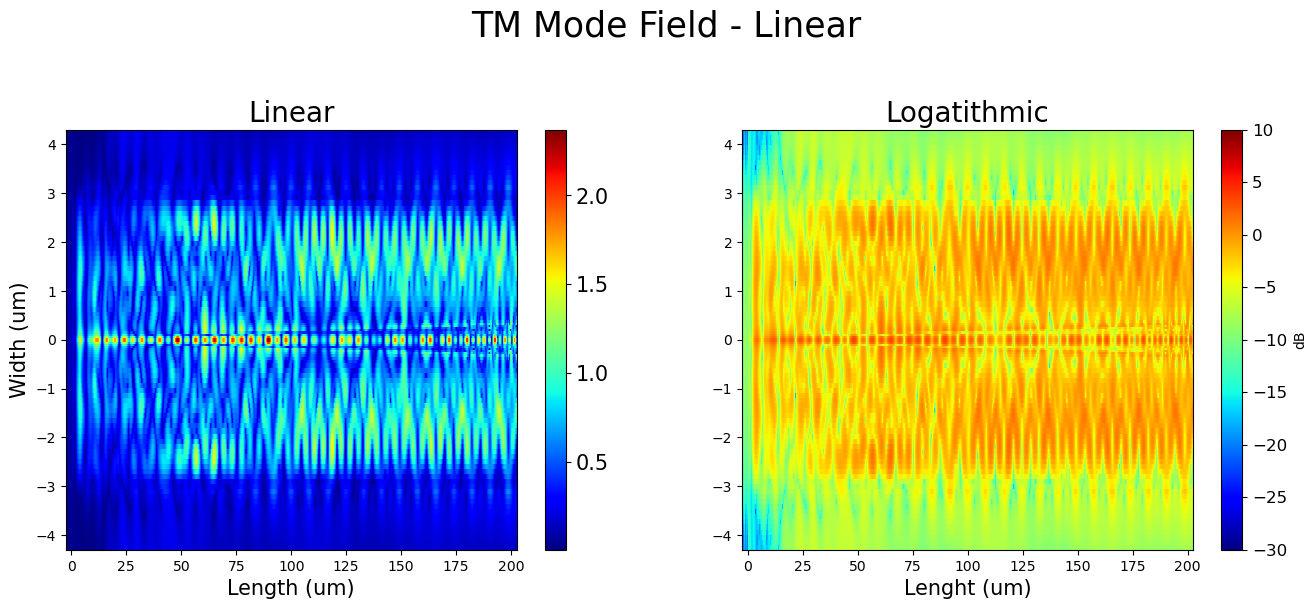

In [9]:
# Plot Linear and Log TM Mode Field Monitor Graph

figure2 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = lum.getresult('field','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.suptitle('TM Mode Field - Linear', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 10)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitorTM_Linear')

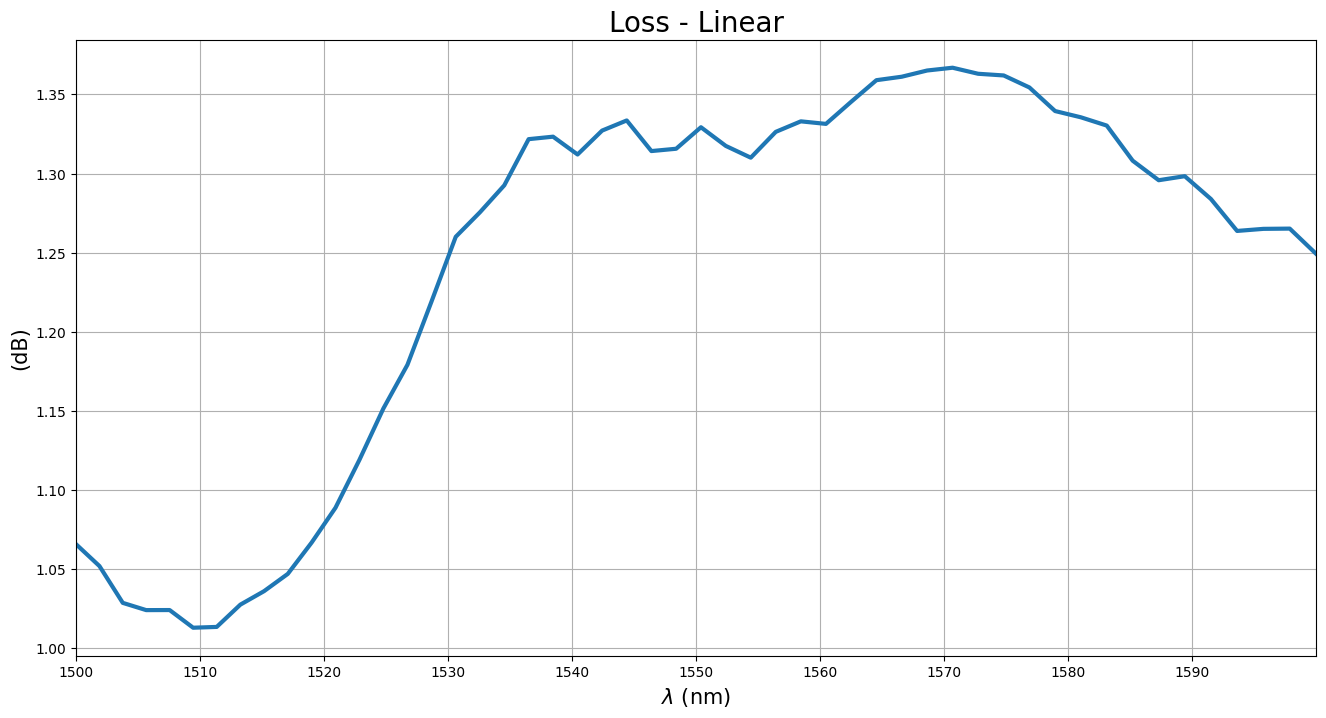

In [5]:
 # Getting results
S = lum.getresult('output', 'T')

T = (S['T'])
Tlog = 10*np.log10(T)
wavelength = S['lambda']

# Plotting insertion loss

figure3 = plt.figure(figsize=(16,8))

plt.title('Loss - Linear', size = 20)

plt.plot(wavelength*1e9, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/Loss_Linear')

In [6]:
with open('SavedData/Loss_Lin.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [7]:
with open('SavedData/Loss_Lin.txt', 'rb') as file:
    Loss_Lin = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Loss_Lin) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.750029,0.747279,0.747306,0.747533,0.744064,0.741600,0.742036,0.739931,0.736158,0.735273,...,0.785788,0.787767,0.789313,0.791874,0.791967,0.789933,0.789940,0.789107,0.784891,0.782413
1,-1.249219,-1.265169,-1.265013,-1.263699,-1.283898,-1.298301,-1.295750,-1.308090,-1.330292,-1.335513,...,-1.046947,-1.036025,-1.027510,-1.013437,-1.012929,-1.024098,-1.024058,-1.028643,-1.051907,-1.065640


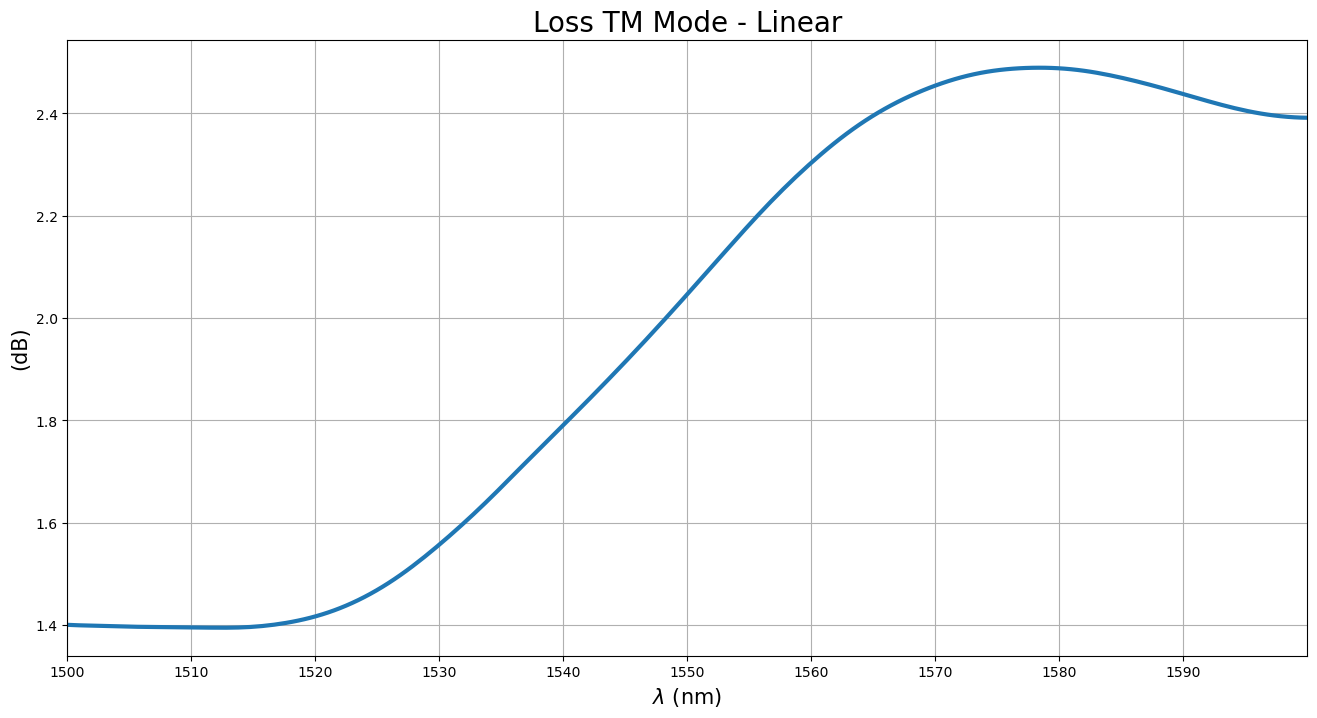

In [13]:
 # Getting results
S = lum.getresult('output', 'T')

T = (S['T'])
Tlog = 10*np.log10(T)
wavelength = S['lambda']

# Plotting transmission and insertion loss

figure4 = plt.figure(figsize=(16,8))

plt.title('Loss TM Mode - Linear', size = 20)

plt.plot(wavelength*1e9, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/LossTM_Linear')

In [14]:
with open('SavedData/Loss_TM_Lin.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [15]:
with open('SavedData/Loss_TM_Lin.txt', 'rb') as file:
    Loss_TM_Exp = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Loss_TM_Exp) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.576552,0.576513,0.576434,0.576316,0.57616,0.575966,0.575734,0.575466,0.575163,0.574826,...,0.724842,0.724794,0.724747,0.724701,0.724655,0.724607,0.724554,0.724495,0.724425,0.724343
1,-2.391619,-2.391910,-2.392504,-2.393392,-2.39457,-2.396034,-2.397780,-2.399802,-2.402091,-2.404633,...,-1.397566,-1.397855,-1.398136,-1.398411,-1.398686,-1.398974,-1.399290,-1.399649,-1.400067,-1.400556


# Exponential

In [2]:
lum = lumapi.FDTD(filename='../CML/Exponential.fsp')

In [20]:
# Using 0.04μm width and 200μm lenght
lum.select('core')
lum.delete()
lum.select('substract')
lum.delete()
lum.select('extension')
lum.delete()


width = 0.04e-6
lenght = 200e-6
N = 2000

x = np.linspace(0,lenght,N)
z = (x-x[0])/(x[int(N/2-1)]-x[0])/2
function = ((np.exp(z) - 1)/(np.exp(1) - 1)*1e-6)/4 + width/2

X, Y, xinvertido, yinvertido = functionstapers(lenght, N, finalwidth, -function)
lum.set({
    'z min'                                      : 0,
    'z max'                                      : height,
    'x'                                          : 0,
    'y'                                          : 0,
    'material'                                   : core,
    'name'                                       : 'core',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})
lum.addrect()
lum.set({
    'x min'                                      : length,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : 0.270198*2e-6,
    'z max'                                      : height,
    'z min'                                      : 0,
    'name'                                       : 'extension',
    'material'                                   : core,
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})

lum.addrect()
lum.set({
    'z'                                          : 0,
    'z span'                                     : 2*burriedlayer,
    'x min'                                      : 0,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : 3*burriedlayer,
    'material'                                   : substract,
    'name'                                       : 'substract',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 2
})



{!!}



C:\Program Files\Lumerical\v202\api\python\lumapi.py:138: UserWarning: Multiple objects named '::model::polygon'. Use of this object may give unexpected results.
  warnings.warn(message)


In [21]:
# Simulation Settings

#time = (length)/c0*3.5
#print(time)

lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()

lum.addpower()
lum.set({
    'z'                               : height/2,
    'x'                               : length/2,
    'x span'                          : length + 5e-6,
    'y'                               : 0,
    'y span'                          : yspan,
    'name'                            : 'field',
    'override global monitor settings':1,
    'frequency points'                : 200
})

lum.addpower()
lum.set('monitor type', '2D X-normal')
lum.set({
    'z'                               : height/2,
    'z span'                          : zspan,
    'x'                               : length + 2e-6,
    'y'                               : 0,
    'y span'                          : yspan,
    'name'                            : 'output',
    'override global monitor settings':1,
    'frequency points'                : 200
})

lum.addmode()
lum.set({
    'x'                : -2.5e-6,
    'y'                : 0,
    'y span'           : yspan,
    'z'                : height/2,
    'z span'           : zspan,
    'name'             : 'port',
    'wavelength start' : 1.5e-6,
    'wavelength stop'  : 1.6e-6
})

lum.addfdtd()
lum.set('allow symmetry on all boundaries', 1)
lum.set({
    'z'               : height/2,
    'z span'          : zspan,
    'x'               : length/2,
    'x span'          : length+5e-6,
    'y'               : 0,
    'y span'          : yspan,
    'mesh accuracy'   : 2,
    #'y min bc'        : 'Anti-Symmetric',
    'z min bc'        : 'Symmetric',
    'z max bc'        : 'Symmetric',
    'simulation time' : time
})

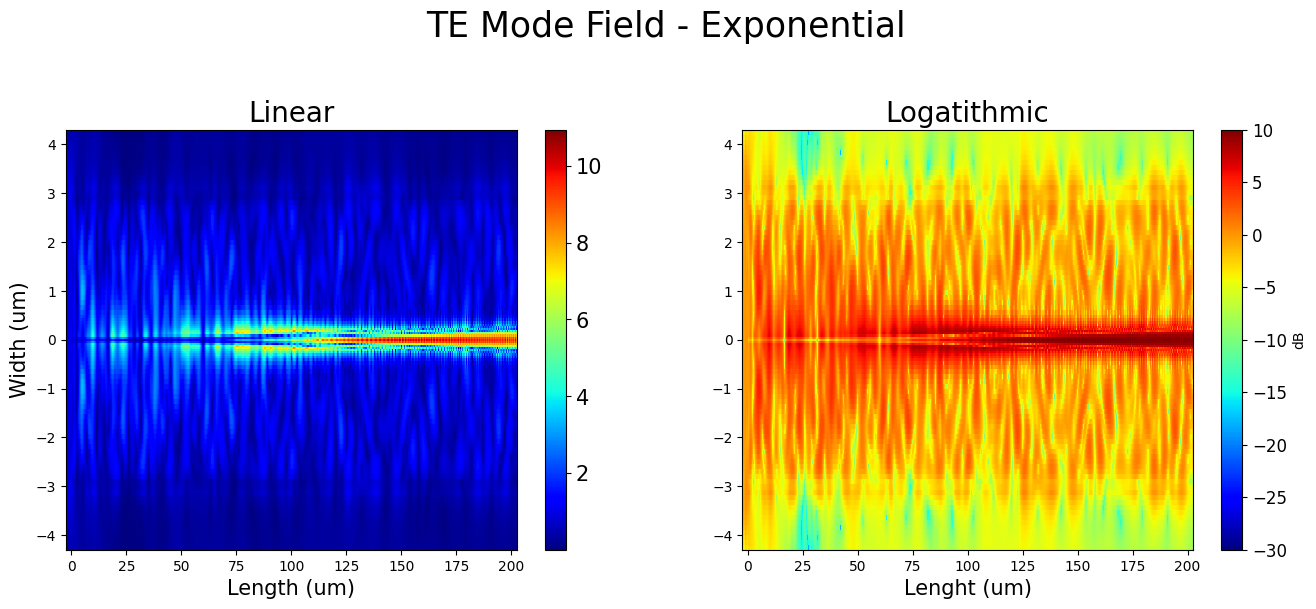

In [32]:
# Plot Linear and Log TE Mode Field Monitor Graph

figure3 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = lum.getresult('field','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.suptitle('TE Mode Field - Exponential', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 10)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitorTE_Exponential')

In [ ]:
# Plot Linear and Log TM Mode Field Monitor Graph

figure3 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = lum.getresult('field','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.suptitle('TM Mode Field - Exponential', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 10)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitorTM_Exponential')

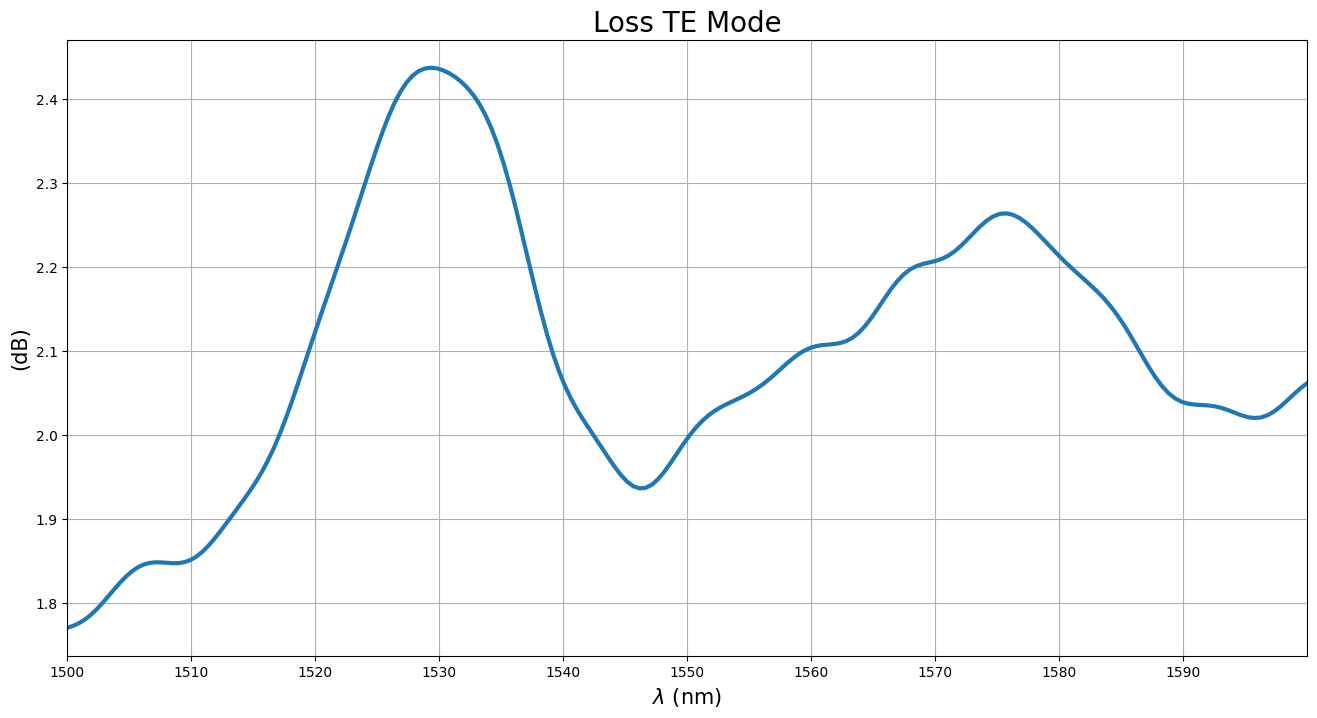

In [23]:
 # Getting results
S = lum.getresult('output', 'T')

T = (S['T'])
Tlog = 10*np.log10(T)
wavelength = S['lambda']

# Plotting transmission and insertion loss

figure4 = plt.figure(figsize=(16,8))

plt.title('Loss TE Mode - Exponential', size = 20)

plt.plot(wavelength*1e9, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/LossTE_Exponential')

In [30]:
with open('SavedData/Loss_TE_Exp.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [31]:
with open('SavedData/Loss_TE_Exp.txt', 'rb') as file:
    Loss_TE_Exp = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Loss_TE_Exp) # Read the .txt file
dataFrame

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.621986,0.622853,0.623862,0.624930,0.625957,0.626842,0.627503,0.627887,0.627988,0.627836,...,0.656947,0.658150,0.659401,0.660631,0.661776,0.662785,0.663624,0.664282,0.664771,0.665122
1,-2.062194,-2.056145,-2.049114,-2.041683,-2.034552,-2.028416,-2.023845,-2.021182,-2.020487,-2.021535,...,-1.824696,-1.816751,-1.808507,-1.800413,-1.792889,-1.786273,-1.780779,-1.776476,-1.773281,-1.770984


In [ ]:
 # Getting results
S = lum.getresult('output', 'T')

T = (S['T'])
Tlog = 10*np.log10(T)
wavelength = S['lambda']

# Plotting transmission and insertion loss

figure4 = plt.figure(figsize=(16,8))

plt.title('Loss TM Mode - Exponential', size = 20)

plt.plot(wavelength*1e9, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/LossTM_Exponential')

In [ ]:
with open('SavedData/Loss_TM_Exp.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [ ]:
with open('SavedData/Loss_TM_Exp.txt', 'rb') as file:
    Loss_TM_Exp = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Loss_TM_Exp) # Read the .txt file
dataFrame

# Quadratic

In [10]:
lum = lumapi.FDTD(filename='../CML/Quadratic.fsp')

In [ ]:
# Using 0.04μm width and 200μm lenght
lum.deleteall()

width = 0.04e-6
lenght = 5e-6
N = 2000

x = np.linspace(0,lenght,N)
z = (x-x[0])/(x[int(N/2-1)]-x[0])/2
function = (z**2/4)*1e-6 + width/2
inversefunction = np.flip(function)

X, Y, xinvertido, yinvertido = functionstapers(lenght, N, width, function)

lum.set({
    'z min'                                      : 0,
    'z max'                                      : height,
    'x'                                          : 0,
    'y'                                          : 0,
    'material'                                   : core,
    'name'                                       : 'core',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})
lum.addrect()
lum.set({
    'x min'                                      : length,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : finalwidth,
    'z max'                                      : height,
    'z min'                                      : 0,
    'name'                                       : 'extension',
    'material'                                   : core,
    'override mesh order from material database' : 1,
    'mesh order'                                 : 1
})

lum.addrect()
lum.set({
    'z'                                          : 0,
    'z span'                                     : 2*burriedlayer,
    'x min'                                      : 0,
    'x max'                                      : length+10e-6,
    'y'                                          : 0,
    'y span'                                     : 3*burriedlayer,
    'material'                                   : substract,
    'name'                                       : 'substract',
    'override mesh order from material database' : 1,
    'mesh order'                                 : 2
})

In [ ]:
# Simulation Settings

#time = (length)/c0*3.5
#print(time)
time = 5e-12

span = 5e-6

lum.select('field')
lum.delete()
lum.select('FDTD')
lum.delete()
lum.select('port')
lum.delete()
lum.select('output')
lum.delete()

lum.addpower()
lum.set({
    'z'                               : height/2,
    'x'                               : length/2,
    'x span'                          : length + 5e-6,
    'y'                               : 0,
    'y span'                          : yspan,
    'name'                            : 'field',
    'override global monitor settings':1,
    'frequency points'                : 200
})

lum.addpower()
lum.set('monitor type', '2D X-normal')
lum.set({
    'z'                               : height/2,
    'z span'                          : zspan,
    'x'                               : length + 2e-6,
    'y'                               : 0,
    'y span'                          : yspan,
    'name'                            : 'output',
    'override global monitor settings':1,
    'frequency points'                : 200
})

lum.addmode()
lum.set({
    'x'                : -2.5e-6,
    'y'                : 0,
    'y span'           : yspan,
    'z'                : height/2,
    'z span'           : zspan,
    'name'             : 'port',
    'wavelength start' : 1.5e-6,
    'wavelength stop'  : 1.6e-6
})

lum.addfdtd()
lum.set('allow symmetry on all boundaries', 1)
lum.set({
    'z'               : height/2,
    'z span'          : zspan,
    'x'               : length/2,
    'x span'          : length+5e-6,
    'y'               : 0,
    'y span'          : yspan,
    'mesh accuracy'   : 2,
    #'y min bc'        : 'Anti-Symmetric',
    'z min bc'        : 'Symmetric',
    'z max bc'        : 'Symmetric',
    'simulation time' : time
})

In [ ]:
# Plot Linear and Log TE Mode Field Monitor Graph

figure1 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = lum.getresult('field','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.suptitle('TE Mode Field - Quadratic', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 10)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitorTE_Quadratic')

In [ ]:
# Plot Linear and Log TM Mode Field Monitor Graph

figure2 = plt.figure(figsize=(16, 12), edgecolor= 'white', facecolor= 'white')

field = lum.getresult('field','E')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])
Elog = 10*np.log10(E)

plt.suptitle('TM Mode Field - Quadratic', fontsize = 25)
plt.subplot(221)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Length (um)',fontsize=15)
plt.ylabel('Width (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Linear", fontsize = 20)

plt.subplot(222)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet', vmin = -30, vmax = 10)
plt.xlabel('Lenght (um)',fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=12)
plt.title("Logatithmic", fontsize = 20)

plt.savefig('../Documentation/Figures/FieldMonitorTM_Quadratic')

In [ ]:
 # Getting results
S = lum.getresult('output', 'T')

T = (S['T'])
Tlog = 10*np.log10(T)
wavelength = S['lambda']

# Plotting transmission and insertion loss

figure3 = plt.figure(figsize=(16,8))

plt.title('Loss TE Mode - Quadratic', size = 20)

plt.plot(wavelength*1e9, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/LossTE_Quadratic')

In [ ]:
with open('SavedData/Loss_TE_Qua.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [ ]:
with open('SavedData/Loss_TE_Qua.txt', 'rb') as file:
    Loss_TE_Qua = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Loss_TE_Qua) # Read the .txt file
dataFrame

In [ ]:
 # Getting results
S = lum.getresult('output', 'T')

T = (S['T'])
Tlog = 10*np.log10(T)
wavelength = S['lambda']

# Plotting transmission and insertion loss

figure4 = plt.figure(figsize=(16,8))

plt.title('Loss TM Mode - Quadratic', size = 20)

plt.plot(wavelength*1e9, -Tlog, linewidth = 3)
plt.xticks(np.arange(1500,1600,10))
plt.xlim(1500,1600)
# plt.yticks(np.arange(-3.25, -2.95,0.05))
# plt.ylim(-3.25,-2.95)
plt.xlabel('$\lambda$ (nm)', size = 15)
plt.ylabel('(dB)', size = 15)
plt.grid()
plt.savefig('../Documentation/Figures/LossTM_Quadratic')

In [ ]:
with open('SavedData/Loss_TM_Qua.txt', 'wb') as file:
    plk.dump([T, Tlog],file)
file.close()

In [ ]:
with open('SavedData/Loss_TM_Qua.txt', 'rb') as file:
    Loss_TM_Qua = plk.load(file)
file.close()
 
#print(data)
dataFrame = pd.DataFrame(Loss_TM_Qua) # Read the .txt file
dataFrame